# Basic example BOTDA

In [1]:
import numpy as np
from numpy import unravel_index
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import ot
import scipy.io
import mne          
from mne.decoding import CSP
mne.set_log_level(verbose='warning') #to avoid info at terminal
import matplotlib.pyplot as pl
from random import seed
seed(30)
from MIOTDAfunctions import*
#ignore warning 
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [2]:
results_acc=[]
results_all=[]
results_all_inv=[]

rango_cl = [0.1, 0.5, 1, 2, 5, 10, 20]
rango_e = [0.1, 0.5, 1, 2, 5, 10, 20]
metrica = 'sqeuclidean'
outerkfold = 10 # for faster online computation select a lower value
innerkfold = dict(nfold=10, train_size=0.8)

## Load and filter data 

In [3]:
fName = 'Data/DataSession1_S9.mat'
s = scipy.io.loadmat(fName)

Data_S1=s["X"]
Labels_S1=s["y"]
Labels_S1=np.squeeze(Labels_S1)

#filterting with mne
[nt, nc, ns]=np.shape(Data_S1)
Data_S1=np.reshape(Data_S1, [nt, nc*ns])
Data_S1=mne.filter.filter_data(Data_S1, 128, 8, 30)
Data_S1=np.reshape(Data_S1, [nt,nc,ns])

fName = 'Data/DataSession2_S9.mat'
s2 = scipy.io.loadmat(fName)

Data_S2=s2["X"]
Labels_S2=s2["y"]
Labels_S2=np.squeeze(Labels_S2)

#filterting with mne
[nt, nc, ns]=np.shape(Data_S2)
Data_S2=np.reshape(Data_S2, [nt, nc*ns])
Data_S2=mne.filter.filter_data(Data_S2, 128, 8, 30)
Data_S2=np.reshape(Data_S2, [nt,nc,ns])

### Learn CSP+LDA from source data (Data_S1)

In [4]:
Xtr = Data_S1
Ytr = Labels_S1
csp = CSP(n_components=6, reg='empirical', log=True, norm_trace=False, cov_est='epoch')
#learn csp filters
Gtr = csp.fit_transform(Xtr, Ytr)
#learn lda
lda = LinearDiscriminantAnalysis()
lda.fit(Gtr,Ytr)

LinearDiscriminantAnalysis()

### As a basic example, we are going to split target data (Data_S2) in 50 % for testing and 50% for the validation set

In [5]:
#testing data
Xte = Data_S2[80:]
Yte = Labels_S2[80:]
#transportation set
Xval = Data_S2[:80]
Yval = Labels_S2[:80]
#feature computation
Gval = csp.transform(Xval)
Gte = csp.transform(Xte)
    
M = len(Yval)
    
#%% # Backward Sinkhorn Transport
# Subset selection
    
G_BOTDAs_, Y_BOTDAs_, regu_BOTDAs_=\
    SelectSubsetTraining_BOTDAs(Gtr, Ytr, Gval, Yval, rango_e, lda, metrica, outerkfold, innerkfold, M)

Gtr_botda=G_BOTDAs_
Ytr_botda=Y_BOTDAs_
    
bot_s = ot.da.SinkhornTransport(metric=metrica, reg_e=regu_BOTDAs_)
    
bot_s.fit(Xs=Gval, ys=Yval, Xt=Gtr_botda)
#transport testing samples
transp_Xt_s_backward=bot_s.transform(Xs=Gte)
# Compute accuracy without retraining    
yt_predict_3=lda.predict(transp_Xt_s_backward)
acc_botdas=accuracy_score(Yte, yt_predict_3)

    
#%% # Backward Group-Lasso Transport
# Subset selection 
G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_=\
    SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metrica, outerkfold, innerkfold, M)
    
Gtr_botda=G_BOTDAl1l2_
Ytr_botda=Y_BOTDAl1l2_
    
bot_l1l2 = ot.da.SinkhornL1l2Transport(metric=metrica, reg_e=regu_BOTDAl1l2_[0], reg_cl=regu_BOTDAl1l2_[1])
    
bot_l1l2.fit(Xs=Gval, ys=Yval, Xt=Gtr_botda)
#transport testing samples
transp_Xt_l1l2_backward=bot_l1l2.transform(Xs=Gte)
# Compute accuracy without retraining    
yt_predict_4=lda.predict(transp_Xt_l1l2_backward)
acc_botdal1l2=accuracy_score(Yte, yt_predict_4)

# print results
acc = {}
acc["botda_s"] = acc_botdas
acc["botda_l1l2"] = acc_botdal1l2
    
print('ACC')   

ACC


In [6]:
acc = {}
acc["botda_s"] = acc_botdas
acc["botda_l1l2"] = acc_botdal1l2
    
print(acc)   

{'botda_s': 0.7625, 'botda_l1l2': 0.75}


### Plotting

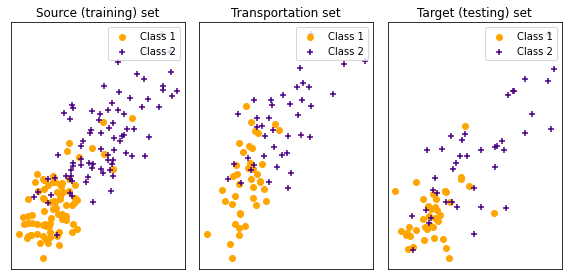

In [7]:
#Plotting

#distribution datasets
pl.figure(figsize=(8, 4))

pl.subplot(1, 3, 1)
pl.scatter(Gtr[Ytr==1, 0], Gtr[Ytr==1, 1], c='orange', marker='o', label='Class 1')
pl.scatter(Gtr[Ytr==2, 0], Gtr[Ytr==2, 1], c='indigo', marker='+', label='Class 2')

pl.xticks([])
pl.yticks([])
pl.legend(loc=1)
pl.title('Source (training) set')

pl.subplot(1, 3, 2)
pl.scatter(Gval[Yval==1, 0], Gval[Yval==1, 1], c='orange', marker='o', label='Class 1')
pl.scatter(Gval[Yval==2, 0], Gval[Yval==2, 1], c='indigo', marker='+', label='Class 2')

pl.xticks([])
pl.yticks([])
pl.legend(loc=1)
pl.title('Transportation set')
pl.tight_layout()

    
pl.subplot(1, 3, 3)
pl.scatter(Gte[Yte==1, 0], Gte[Yte==1, 1], c='orange', marker='o', label='Class 1')
pl.scatter(Gte[Yte==2, 0], Gte[Yte==2, 1], c='indigo', marker='+', label='Class 2')

pl.xticks([])
pl.yticks([])
pl.legend(loc=1)
pl.title('Target (testing) set' )
pl.tight_layout()



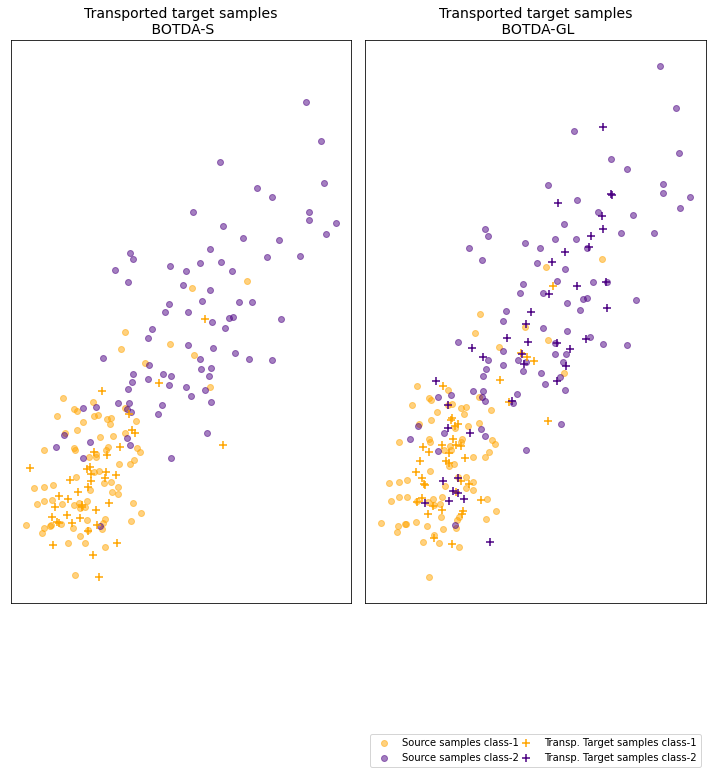

In [8]:
# plotting original and transported samples for each method
pl.figure(figsize=(10, 11))
    
#BOTDA-S
pl.subplot(1, 2, 1)
pl.scatter(Gtr[Ytr==1, 0], Gtr[Ytr==1, 1], c='orange', marker='o',alpha=0.5)
pl.scatter(Gtr[Ytr==2, 0], Gtr[Ytr==2, 1], c='indigo', marker='o',alpha=0.5)

pl.scatter(transp_Xt_s_backward[Yte==1, 0], transp_Xt_s_backward[Yte==1, 1], c='orange',
            marker='+', s=50)
pl.scatter(transp_Xt_s_backward[Yte==2, 0], transp_Xt_s_backward[Yte==2, 1], c='indigo',
            marker='+', s=0)
pl.title('Transported target samples\n BOTDA-S', size=14)
pl.xticks([])
pl.yticks([])

    
#BOTDA-GL
pl.subplot(1, 2, 2)
pl.scatter(Gtr[Ytr==1, 0], Gtr[Ytr==1, 1], c='orange', marker='o',alpha=0.5, 
           Label='Source samples class-1')
pl.scatter(Gtr[Ytr==2, 0], Gtr[Ytr==2, 1], c='indigo', marker='o',alpha=0.5,
           Label='Source samples class-2')

pl.scatter(transp_Xt_l1l2_backward[Yte==1, 0], transp_Xt_l1l2_backward[Yte==1, 1], c='orange',
            marker='+', s=50, Label='Transp. Target samples class-1')
pl.scatter(transp_Xt_l1l2_backward[Yte==2, 0], transp_Xt_l1l2_backward[Yte==2, 1], c='indigo',
            marker='+', s=50, Label='Transp. Target samples class-2')
pl.title('Transported target samples\n BOTDA-GL', size=14)
pl.legend(loc=8, ncol=2, mode="expand", bbox_to_anchor=(0, -0.3, 1, 0.65))
pl.xticks([])
pl.yticks([])
pl.tight_layout()